In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pytesseract
from pytesseract import Output
plt.rcParams['figure.figsize'] = [20, 15]

def iswhite(color):
    return color>=250

def find_grid_bounds(img):
    y_end, x_end = img.shape[:2]
    y_end-=1
    x_end-=1
    x_start, y_start = 0,0
    curx = x_start
    cury = y_start
    bound = {}
    while curx<x_end:
        found=False
        cury=y_start
        while cury<y_end and iswhite(img[cury,curx]):
            cury+=1
        if not cury>=y_end/2:
            found=True
            break
        if found:
            break
        curx+=1
    bound['x_start']=curx
    bound['y_start']=cury
    
    cury=y_end
    curx=x_end
    while curx>=0:
        found=False
        cury=y_end
        while cury>=0 and iswhite(img[cury,curx]):
            cury-=1
        if cury>(2*y_end)/3:
            found=True
            break
        if found:
            break
        curx-=1
    bound['x_end']=curx
    bound['y_end']=cury
    cv2.rectangle(img,(bound['x_start'],bound['y_start']),(bound['x_end'],bound['y_end']),(0,255,0),2)
    plt.imshow(img)
    return bound


def get_mids(bounds):
    midx = int((bounds['x_end']-bounds['x_start'])/2)+90
    midy = int((bounds['y_end']-bounds['y_start'])/2)+90
    return midx,midy

def overlay_grid(img,bounds,typ):
    gap=3
    white=(255,255,255)
    thickness=1
    cross_hair = 20
    err=10
    midx,midy=get_mids(bounds)
        
    if typ=='hor':
        for x in range(bounds['x_start'],bounds['x_end']+1,gap):
            if abs(x-midx)<=cross_hair:
                continue
            cv2.line(img, (x, bounds['y_start']-err), (x, midy-cross_hair), 255, thickness)
            cv2.line(img, (x, midy+cross_hair), (x, bounds['y_end']+err), 255, thickness)

    if typ=='ver':
        for y in range(bounds['y_start'],bounds['y_end']+1,gap):
            if abs(y-midy)<=cross_hair:
                continue
            cv2.line(img, (bounds['x_start']-err,y), (midx-cross_hair,y), 255, thickness)
            cv2.line(img, (midx+cross_hair,y), (bounds['x_end']+err,y), 255, thickness)

def add_axis_labels(img,bounds):
    size=40
    midx, midy = get_mids(bounds)
    x_coords = (bounds['x_end']+20,midy-20)
    y_coords = (midx-20,bounds['y_start']-60)
    x = cv2.cvtColor(cv2.imread('x.png'), cv2.COLOR_BGR2GRAY)
    x = cv2.resize(x, (size,size), interpolation = cv2.INTER_AREA) 
    y = cv2.cvtColor(cv2.imread('y.png'), cv2.COLOR_BGR2GRAY)
    y = cv2.resize(y, (size,size), interpolation = cv2.INTER_AREA) 
    img[x_coords[1]:x_coords[1]+size, x_coords[0]:x_coords[0]+size] = x
    img[y_coords[1]:y_coords[1]+size, y_coords[0]:y_coords[0]+size] = y


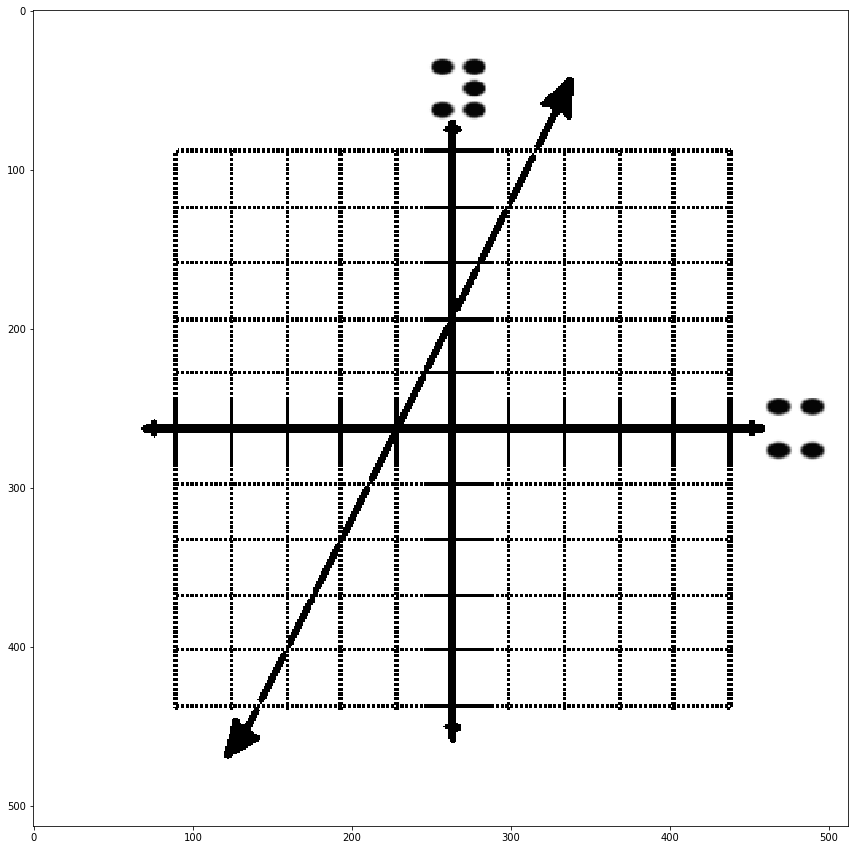

In [8]:
img = cv2.imread('linegraph.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

bounds = find_grid_bounds(img)

#find axes
kernel_y = np.ones((100,1), np.uint8)
kernel_x = np.ones((1,100), np.uint8)
yaxis = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel_y)
xaxis = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel_x)

#find figure
curve = cv2.add(gray, (255-xaxis-yaxis))
ret, thresh_img = cv2.threshold(curve, 180, 255, cv2.THRESH_BINARY)

#line = thresh_img
curve = cv2.medianBlur(thresh_img, 5)

#make axes dotted
overlay_grid(yaxis,bounds,"ver")
overlay_grid(xaxis,bounds,"hor")
axes = np.minimum(xaxis,yaxis)
_,axes = cv2.threshold(axes, 180, 255, cv2.THRESH_BINARY)

#final
final = np.minimum(axes,curve)

#add labels
add_axis_labels(final,bounds)

plt.imshow(final, cmap = plt.cm.gray)



### 